In [1]:
#Replacing a Black-box model by a Global Single Tree Approximation
#A regression case - Violent Crime
#Laurent Deborde 2019 march 24th

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import random as rd

In [1]:
# load the data (violent crime usual data less crime stats + columns names)
# data source is http://archive.ics.uci.edu/ml/datasets/communities+and+crime
#Creator: Michael Redmond (redmond '@' lasalle.edu); Computer Science; La Salle University; Philadelphia, PA, 19141, USA 
#-- culled from 1990 US Census, 1995 US FBI Uniform Crime Report, 1990 US Law Enforcement Management and Administrative Statistics Survey, available from ICPSR at U of Michigan. 
#-- Donor: Michael Redmond (redmond '@' lasalle.edu); Computer Science; La Salle University; Philadelphia, PA, 19141, USA 
#-- Date: July 2009

In [17]:
d=pd.read_excel('VCrimeU_C.xls')

In [18]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 127 entries, communityname to nonViolPerPop
dtypes: float64(110), int64(16), object(1)
memory usage: 2.1+ MB


In [19]:
d.columns

Index(['communityname', 'population', 'householdsize', 'racepctblack',
       'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21',
       'agePct12t29', 'agePct16t24',
       ...
       'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg',
       'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn',
       'PolicBudgPerPop', 'ViolentCrimesPerPop', 'nonViolPerPop'],
      dtype='object', length=127)

In [20]:
d.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop,nonViolPerPop
count,2.215000e+03,2205.000000,2193.000000,2215.000000,2197.000000,2200.000000,2215.000000,2215.000000,2212.000000,2207.000000,...,2215.000000,2062.000000,343.000000,3.430000e+02,343.000000,92.0,324.000000,3.430000e+02,1993.000000,2118.000000
mean,5.311798e+04,2.706907,9.402303,83.979819,2.668411,7.983927,14.445837,27.644840,13.982794,11.857096,...,2783.835034,3.244952,185.478134,3.217602e+07,87.130933,10.0,6.568086,1.535779e+05,589.374496,4908.241804
std,2.046203e+05,0.333732,14.300521,16.419080,4.487139,14.632392,4.518623,6.181517,5.971151,4.771670,...,2828.993341,5.024095,318.542834,1.104566e+08,10.349612,0.0,4.397051,2.030409e+05,614.797082,2739.708901
min,1.000500e+04,1.600000,0.010000,2.680000,0.030000,0.120000,4.580000,9.380000,4.640000,1.660000,...,10.000000,0.020000,20.000000,2.380215e+06,10.850000,10.0,0.440000,1.526040e+04,5.350000,116.790000
25%,1.436600e+04,2.500000,0.850000,76.320000,0.610000,0.920000,12.250000,24.415000,11.320000,8.785000,...,1181.900000,0.490000,54.000000,7.275060e+06,84.295000,10.0,4.010000,8.809435e+04,161.730000,2918.070000
50%,2.279200e+04,2.650000,2.880000,90.350000,1.230000,2.185000,13.620000,26.780000,12.550000,11.760000,...,2027.300000,1.390000,86.000000,1.116411e+07,89.580000,10.0,5.600000,1.145820e+05,374.070000,4425.450000
75%,4.302400e+04,2.840000,11.430000,96.225000,2.660000,7.880000,15.360000,29.205000,14.350000,14.420000,...,3321.700000,3.560000,189.500000,2.014754e+07,93.200000,10.0,7.870000,1.556557e+05,794.410000,6229.280000
max,7.322564e+06,5.280000,96.670000,99.630000,57.460000,95.290000,54.400000,70.510000,63.620000,52.770000,...,44229.900000,54.330000,3187.000000,1.617293e+09,99.940000,10.0,48.440000,2.422367e+06,4877.060000,27119.760000


In [21]:
#we won't use the nonViolentCrime column 
d=d.drop('nonViolPerPop',axis=1)

In [22]:
#drop points for which the target is unknown
d=d.dropna(subset={'ViolentCrimesPerPop'})

In [25]:
#for the sake of simplicity we will drop line and columns with too many missing values 

In [23]:
#drop community name (not an index as its repeated)
d=d.drop('communityname',axis=1)

In [24]:
# drop columns with too many missing values
d=d.drop('numbUrban',axis=1)
d=d.drop('pctUrban',axis=1)
d1=d
for colonne in d.columns:
    if d[colonne].isnull().sum() > 1000:
        d1=d1.drop(colonne,axis=1)

In [26]:
#for the sake drop lines with missing values 
d1=d1.dropna()

In [28]:
d1.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,MedOwnCostPctIncNoMt,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,ViolentCrimesPerPop
count,1.050000e+03,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,...,1050.000000,1050.000000,1050.00000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,6.408722e+04,2.703981,11.220505,80.778552,3.023848,9.593867,14.502476,28.288019,14.313457,11.577676,...,13.026095,8.292000,58.64019,49.441638,76.080390,86.820752,36.714667,3010.049143,3.422019,687.176371
std,1.522935e+05,0.337810,15.086994,17.167271,4.748110,15.156706,4.131349,5.821422,5.561958,4.689792,...,1.478581,9.081596,16.75484,10.155655,10.530017,7.766938,155.324683,3142.959621,5.374771,658.052239
min,1.012900e+04,1.880000,0.100000,7.210000,0.120000,0.260000,5.290000,10.550000,4.930000,1.660000,...,10.100000,0.410000,7.85000,15.100000,30.330000,40.400000,0.900000,10.000000,0.020000,5.350000
25%,1.921400e+04,2.500000,1.225000,71.522500,0.750000,1.110000,12.390000,25.180000,11.682500,8.562500,...,11.900000,2.492500,46.75250,42.510000,71.175000,83.547500,9.100000,1315.250000,0.490000,227.622500
50%,3.099400e+04,2.640000,4.580000,86.445000,1.425000,3.085000,13.760000,27.315000,12.900000,11.500000,...,12.800000,4.960000,60.14500,49.850000,77.865000,88.920000,17.350000,2169.600000,1.465000,462.140000
75%,5.691550e+04,2.830000,15.352500,94.417500,3.085000,10.865000,15.470000,29.810000,14.895000,14.117500,...,13.700000,10.547500,72.47750,56.500000,83.370000,92.127500,31.150000,3398.425000,3.650000,919.220000
max,3.485398e+06,5.280000,89.950000,99.280000,45.190000,93.870000,50.800000,70.510000,63.620000,52.770000,...,23.400000,59.720000,91.12000,75.700000,95.810000,97.730000,3569.800000,44229.900000,52.590000,4026.590000


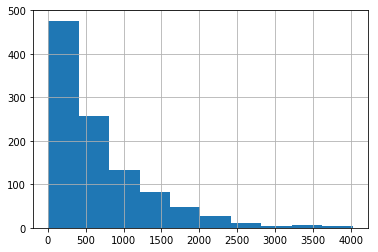

In [29]:
d1['ViolentCrimesPerPop'].hist()

In [30]:
#separate the target and spilt between train and test
y=d1['ViolentCrimesPerPop']
X=d1.drop('ViolentCrimesPerPop',axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## let's try to find a simple tree model

In [35]:
param_grid = {'max_depth': range(1,15)}
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [36]:
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5,
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Best parameters: {'max_depth': 3}
Best cross-validation score: 0.47
Test set score: 0.45


In [37]:
### fit that tree on the whole training set
k=3
tree = DecisionTreeRegressor(max_depth=k)
tree.fit(X_train,y_train)
R2_appr=tree.score(X_train,y_train)
R2_test=tree.score(X_test,y_test)
print('for depth',k)
print("R2 on training set is {:.2f}".format(R2_appr))
print("R2 on test is {:.2f}".format(R2_test))

for depth 3
R2 on training set is 0.67
R2 on test is 0.45


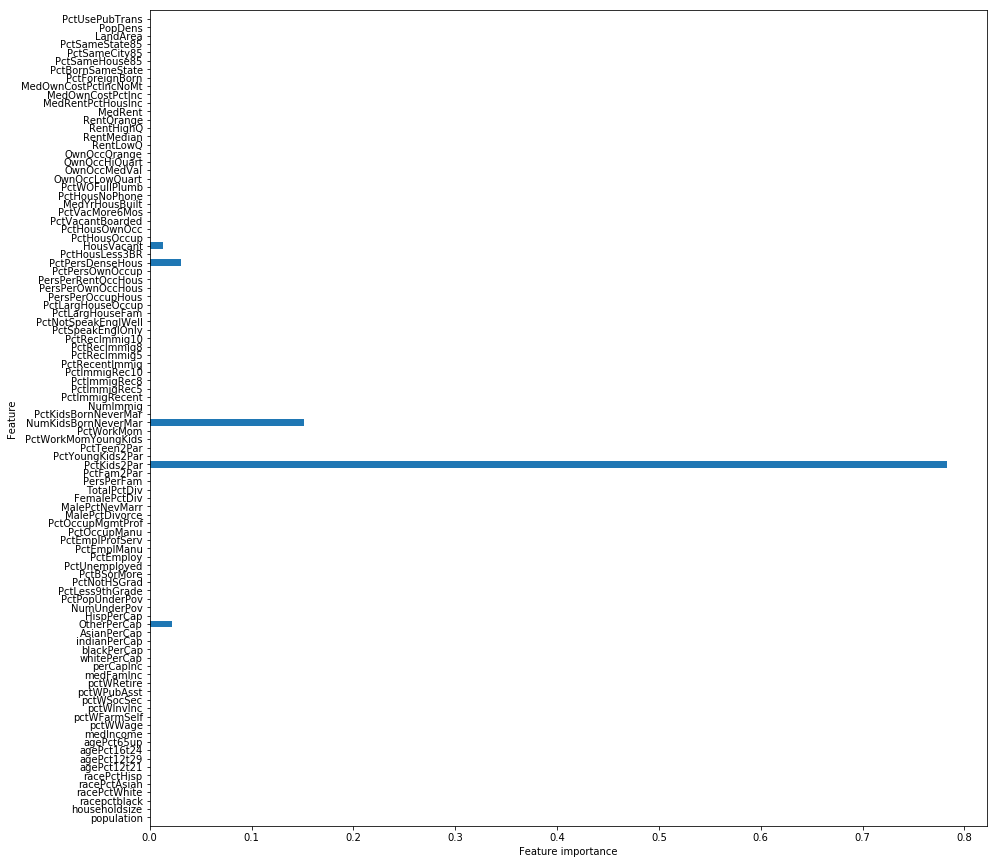

In [38]:
# adapted from Muller & Guido 
# https://github.com/amueller/introduction_to_ml_with_python/blob/master/02-supervised-learning.ipynb

def plot_feature_importances(model, Frame):
    plt.clf()
    n_features=len(Frame.columns)
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), Frame.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)


plot_feature_importances(tree,X_train)
plt.show()  

### Let's try a more complex model : Random forest

### with default parameters

In [39]:
from sklearn.ensemble import RandomForestRegressor
rdf = RandomForestRegressor()
np.set_printoptions(precision=3)
rdf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [40]:
print("pour max_depth non limité le R2 in sample est de {:.2f}".format(rdf.score(X_train,y_train)))
print("et le R2 out of sample est de {:.2f}".format(rdf.score(X_test,y_test)))

pour max_depth non limité le R2 in sample est de 0.92
et le R2 out of sample est de 0.61


### It's more efficient than the single tree. Let's also try Gradient Boosting

### with default parameters

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

In [42]:
gbr = GradientBoostingRegressor()
np.set_printoptions(precision=3)
gbr.fit(X_train,y_train)
print("le R2 in sample est de {:.2f}".format(gbr.score(X_train,y_train)))
print("et le R2 out of sample est de {:.2f}".format(gbr.score(X_test,y_test)))

le R2 in sample est de 0.93
et le R2 out of sample est de 0.65


### Quite good. Let's suppose we are not allowed to use those complex black box models. We will try to use the knowledge gained from those models to build a more efficient single tree. In order to achieve that, we will generate additionnal unlabeled data. We will then use the black box as a oracle to label those data, and train a tree on the new data. 

### First let's genereate additionnal (unlabeled) data, similar to the data from the training set. We wil draw randomly those points from a multivariate gaussian distribution estimated on the training set (we didn't perform test to verify that the initial data distribution is indeed more or less gaussian. If our approach fail then we will have a look at the actual training set to decide another distribution to use). 

In [43]:
# estimate mean and variance on the training set
echmean=X_train.mean(axis=0)
echcov= X_train.cov()

In [45]:
# randomly draw points according to a multivariate distribution with such parameters
X_virt= np.random.multivariate_normal(echmean, echcov, 10000)

D:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


In [46]:
print(X_virt.shape)

(10000, 96)


In [47]:
d_virt=pd.DataFrame(X_virt, columns=X_train.columns)
d_virt.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,MedOwnCostPctInc,MedOwnCostPctIncNoMt,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,66573.315841,2.705809,11.515090,80.652278,3.089249,9.145916,14.495645,28.333771,14.356881,11.601413,...,21.393853,13.079326,8.139259,59.335357,49.848035,76.489240,87.066440,37.890711,2986.931696,3.564345
std,123058.080265,0.349186,15.059706,17.463788,4.986944,15.038292,4.366464,6.055458,5.864310,4.687370,...,2.893516,1.490324,8.990881,16.545429,10.246738,10.611036,7.624601,150.014370,2965.721943,5.494447
min,-429525.306596,1.250576,-44.415062,14.678449,-13.854879,-46.295642,-2.668181,3.621755,-8.754094,-7.983561,...,9.353743,8.137280,-26.280770,-6.830894,12.748081,34.869756,54.343077,-522.566887,-7949.431524,-16.343034
25%,-18758.394877,2.464767,1.730014,68.759663,-0.271134,-0.983208,11.526544,24.167869,10.357358,8.447661,...,19.478823,12.076508,2.056403,48.150934,43.055493,69.242789,81.966967,-63.445145,978.731437,-0.123268
50%,68218.221921,2.707760,11.536784,80.976489,3.035956,9.113696,14.513375,28.363664,14.345764,11.592319,...,21.391075,13.075078,8.076859,59.497296,49.844510,76.428443,87.028876,36.863548,2978.381372,3.587335
75%,151174.857221,2.942379,21.498220,92.112256,6.480872,19.229481,17.482827,32.393697,18.367032,14.784722,...,23.345506,14.076448,14.151000,70.445195,56.606227,83.655737,92.294077,139.728264,4929.300664,7.240451
max,518082.588944,4.058364,75.549478,144.192558,20.753612,71.572084,30.409016,52.656305,36.327834,29.684495,...,32.277046,20.187911,45.073471,115.125160,87.766202,118.673852,121.071668,641.299903,13811.609161,23.291841


#### Label the new data using the Gradient Boosting as an oracle

In [48]:
y_virt=gbr.predict(d_virt)
print(y_virt)

[ 823.987 1251.288  866.209 ...  760.025  622.49  1980.442]


### Let's try to train a tree on these virtual data

In [49]:
for i in range (3,12):
    tree = DecisionTreeRegressor(max_depth=i,random_state=42)
    score=cross_val_score(tree,d_virt,y_virt,cv=5).mean() 
    print("k=",i,"average cross-validation score: {:.2f}".format(score))

k= 3 average cross-validation score: 0.68
k= 4 average cross-validation score: 0.74
k= 5 average cross-validation score: 0.79
k= 6 average cross-validation score: 0.82
k= 7 average cross-validation score: 0.83
k= 8 average cross-validation score: 0.84
k= 9 average cross-validation score: 0.84
k= 10 average cross-validation score: 0.83
k= 11 average cross-validation score: 0.82


###  Is our new single tree a good predictor ? Let's check on the test set

In [51]:
# optimum is at k=8
k=8
tree = DecisionTreeRegressor(max_depth=k)
tree.fit(d_virt,y_virt)
R2_appr=tree.score(X_train,y_train)
R2_test=tree.score(X_test,y_test)
print('for depth',k)
print("R2 on training set is {:.2f}".format(R2_appr))
print("R2 on test is {:.2f}".format(R2_test))

for depth 8
R2 on training set is 0.68
R2 on test is 0.55


### Yes it is ! The impromvement over the initial tree is quite significant : the R2 is halfway between the initial tree and the Gradient Boosting.

### Let's try also with the Random Forest

In [52]:
z_virt=rdf.predict(d_virt)

In [53]:
for i in range (3,12):
    tree1 = DecisionTreeRegressor(max_depth=i,random_state=42)
    score=cross_val_score(tree1,d_virt,z_virt,cv=5).mean() 
    print("k=",i,"average cross-validation score: {:.3f}".format(score))

k= 3 average cross-validation score: 0.818
k= 4 average cross-validation score: 0.846
k= 5 average cross-validation score: 0.860
k= 6 average cross-validation score: 0.866
k= 7 average cross-validation score: 0.866
k= 8 average cross-validation score: 0.864
k= 9 average cross-validation score: 0.860
k= 10 average cross-validation score: 0.852
k= 11 average cross-validation score: 0.843


In [54]:
# optimum is k=6
k=6
tree1 = DecisionTreeRegressor(max_depth=k)
tree1.fit(d_virt,y_virt)
R2_appr=tree1.score(X_train,y_train)
R2_test=tree1.score(X_test,y_test)
print('pour une profondeur de',k)
print("le R2 sur l'échantillon d'apprentissage original est de {:.2f}".format(R2_appr))
print("et le R2 sur le vrai échantillon de test est de {:.2f}".format(R2_test))

pour une profondeur de 6
le R2 sur l'échantillon d'apprentissage original est de 0.65
et le R2 sur le vrai échantillon de test est de 0.51


## Logicaly, as the random forest is less performing than the gradient boosting, so is the RF-helpded tree less performing than the (more deep) GB-helped tree.

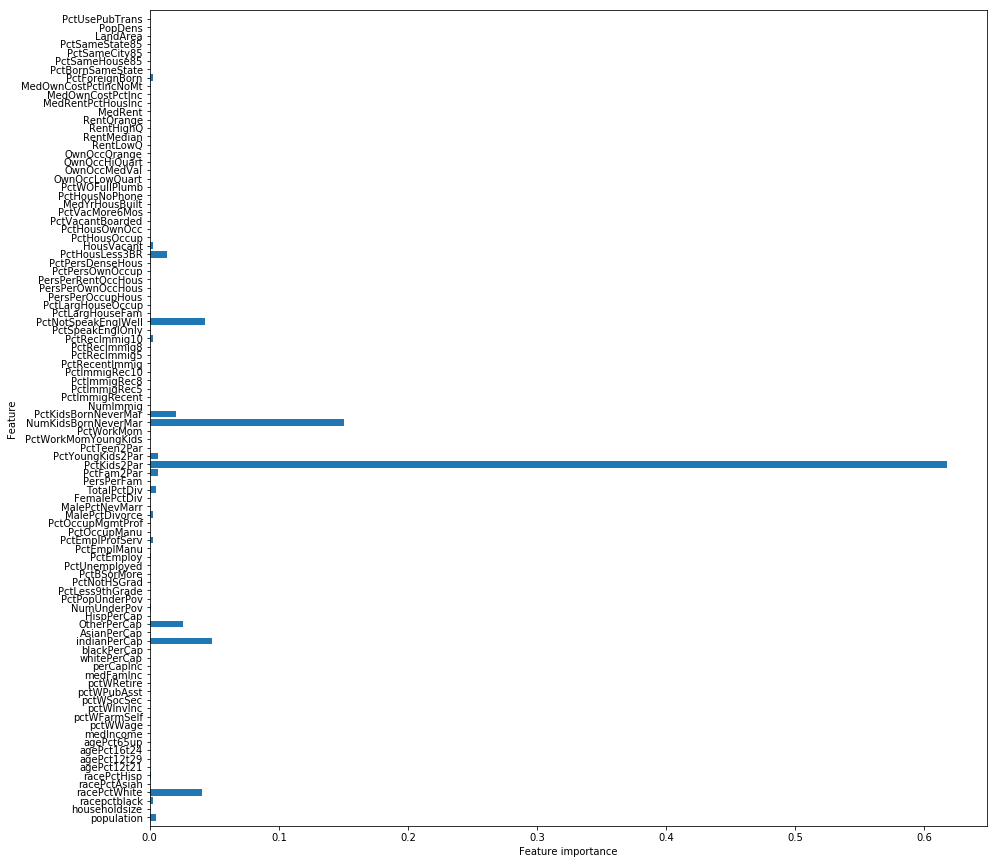

In [55]:
# adapted from Muller & Guido 
# https://github.com/amueller/introduction_to_ml_with_python/blob/master/02-supervised-learning.ipynb

def plot_feature_importances(model, Frame):
    plt.clf()
    n_features=len(Frame.columns)
    plt.figure(figsize=(15,15))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), Frame.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)


plot_feature_importances(tree1,X_train)
plt.show()  